In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
import xgboost as xgb

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

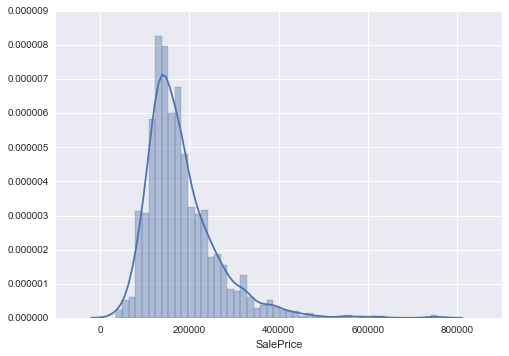

In [4]:
sns.distplot(train.SalePrice)
train.SalePrice.describe()

# Some related variables to SalePrice

## GrLivArea
Above grade (ground) living area square feet

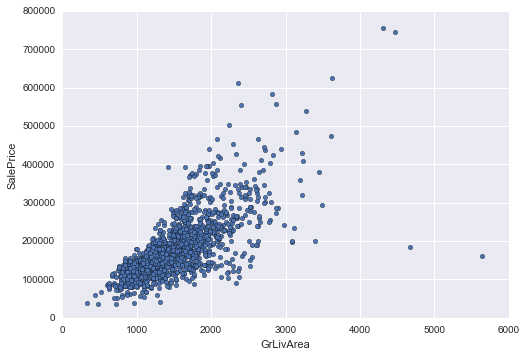

In [5]:
var = 'GrLivArea'
data = pd.concat([train.SalePrice, train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 8e5))

Basically, they are with linear relationship

## TotalBsmtSF
Total square feet of basement area

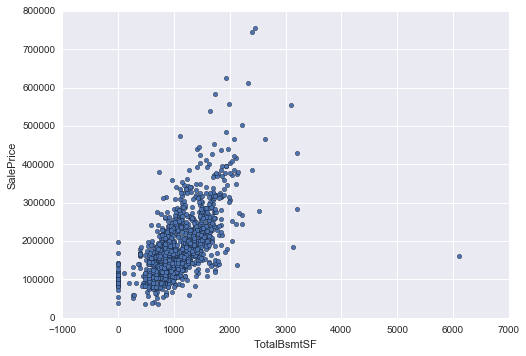

In [6]:
var = 'TotalBsmtSF'
data = pd.concat([train.SalePrice, train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 8e5))

A strong linear(exponential?) and SalePrice grows still when TotalBsmtSF is **zero**

## OverallQual
Rates the overall material and finish of the house

(0, 800000.0)

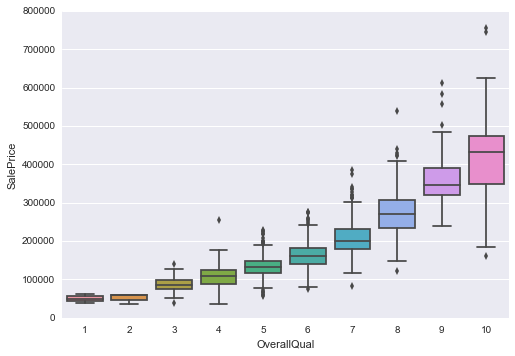

In [7]:
var = 'OverallQual'
data = pd.concat([train.SalePrice, train[var]], axis=1)
sns.boxplot(x=var, y='SalePrice', data=data)
plt.ylim((0, 8e5))

## YearBuilt
Original construction date

(0, 800000.0)

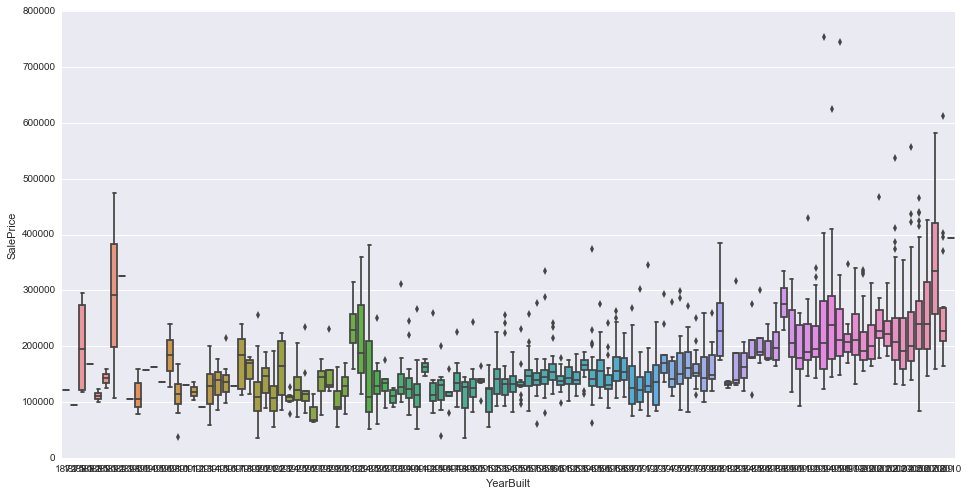

In [8]:
var = 'YearBuilt'
data = pd.concat([train.SalePrice, train[var]], axis=1)
plt.subplots(figsize=(16, 8))
sns.boxplot(x=var, y='SalePrice', data=data)
plt.ylim((0, 8e5))

Although it's not a strong tendency, but 'SalePrice' is more prone to be a little more expensive on new stuff rather than old relics.

# Correlation matrix

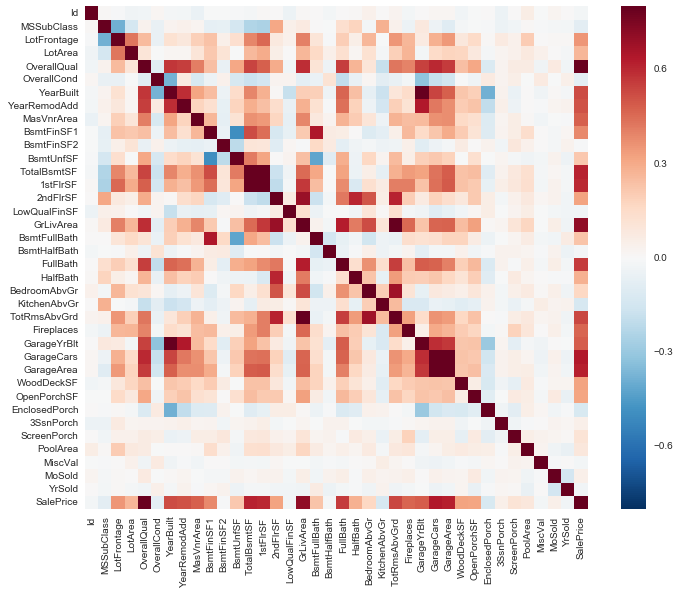

In [9]:
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

# 'SalePrice' correlation matrix

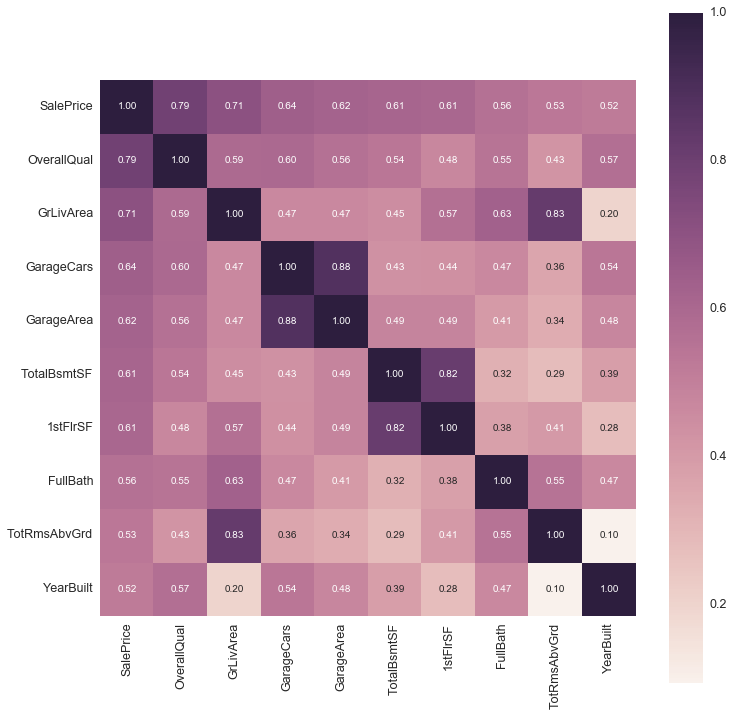

In [10]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
plt.subplots(figsize=(12, 12))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values)

According to the correlation matrix, these are the variables most correlated with 'SalePrice':
* 'OverallQual' and 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, the number
    of cars that fit into the garage is a consequence of the garage area. Therefore, we just need one of them
    to get work down.
* 'TotalBsmtSF' and '1stFlrSF' are also highly related, we can keep 'TotalBsmtSF'.
* 'TotRmsAbvGrd' and 'GrLivArea' are highly related again.

## Scatter plots between 'SalePrice' and correlated variables

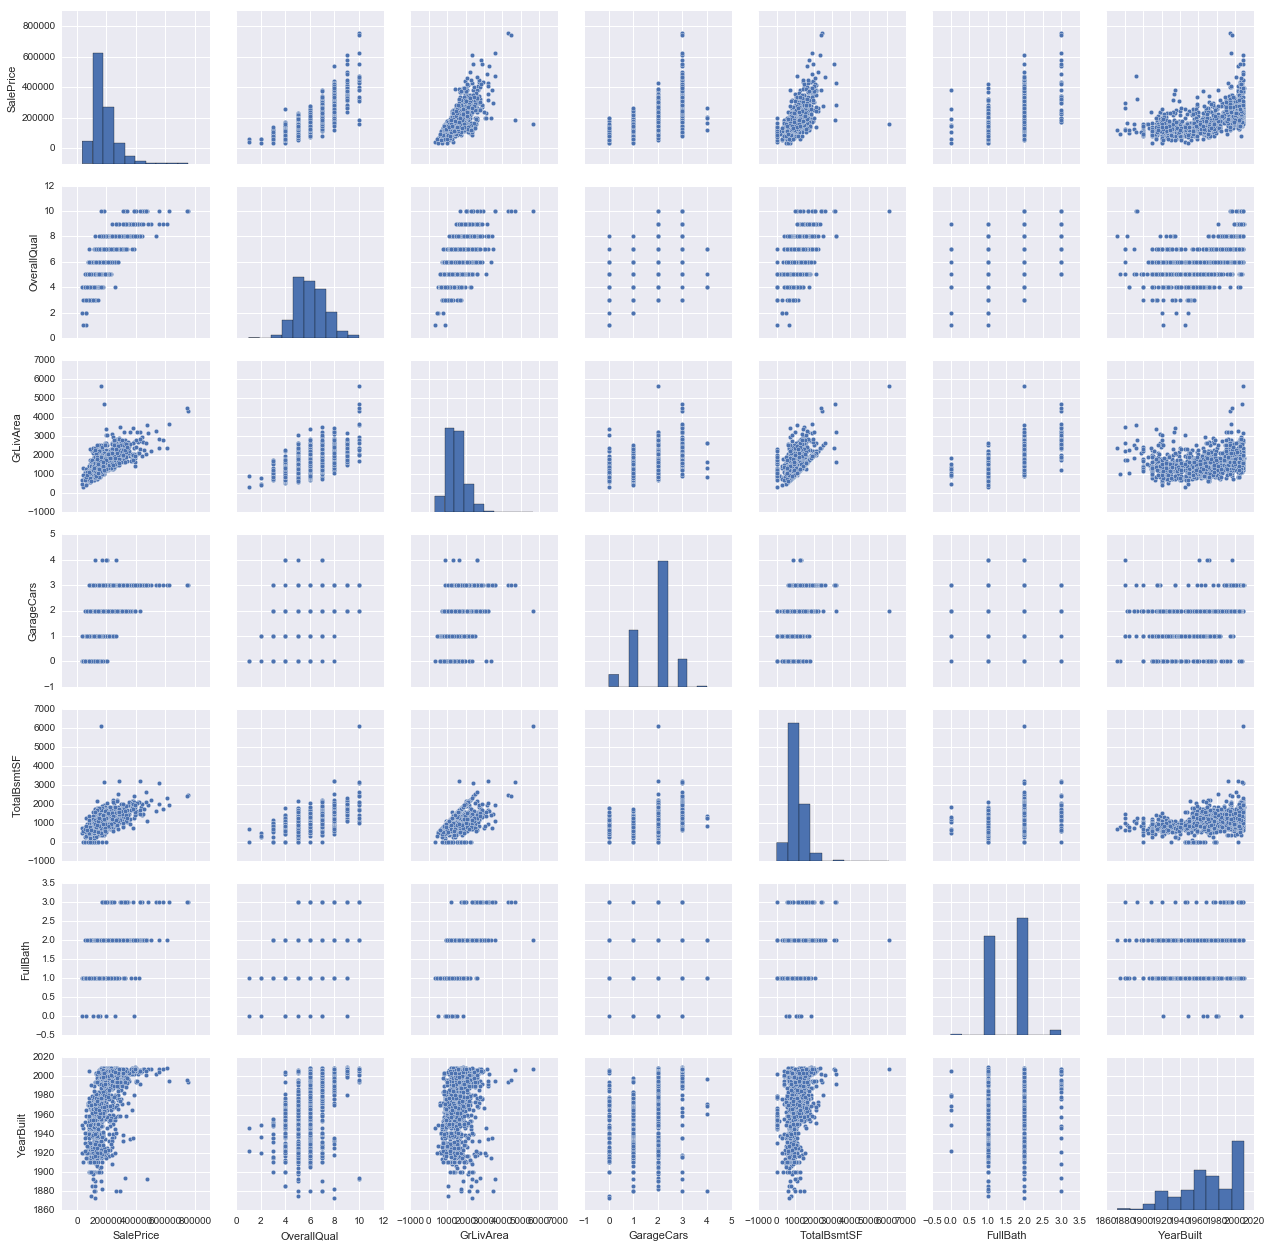

In [11]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
        'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size=2.5)

# Missing data

In [12]:
# missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=('Total', 'Percent'))
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Let's analyse this to understand how to handle the missing data:
* We'll consider that when more than 15% data is missing, we should delete the corresponding variable and pretend it never existed.
* We can see that 'GarageX' variables have the same number of missing data. Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, we will delete the mentioned 'GarageX' variables, the same for 'BsmtX' variables.
* Regarding 'MasVnrArea' and 'MasVnrType', they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we deleted 'MasVnrArea' and 'MasVnrType'.
* Finally, we have one missing observation in 'Electrical', since it is just one observation, we'll delted this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [13]:
# dealing with missing data
train = train.drop((missing_data[missing_data['Total'] > 1]).index, axis=1)
train = train.drop(train.loc[train.Electrical.isnull()].index)
train.isnull().sum().max()

0

# Outliers
Outliers is also something that we should be aware of, because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

## Univariate analysis

In [14]:
saleprice_scaled = StandardScaler().fit_transform(
    train['SalePrice'][:, np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('outer range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]
outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


* Low range values are similar and not too far from 0.
* High range values are far from 0 and the 7.x values are really out of range.

For now, we'll not consider any of these values as an outlier but we should be careful with those two 7.x values.

## Bivariate analysis
We already know the following scatter plots, however, when we look to thing sfrom a new perspective, there's always something to discover.

## Bivariate analysis SalePrice/GrLivArea

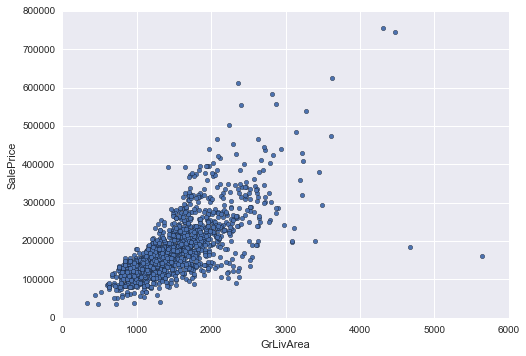

In [15]:
# bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 8e5))

What has been revealed:
* The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural are and that could explain the low price. We'll define them as outliers and delete them cause these two points are not representative of the typical case.
* Thw two observations in the top of the plot are those 7.x observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [16]:
# Finding out outliers
train.sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [17]:
train = train.drop(train[train.Id == 1299].index)
train = train.drop(train[train.Id == 524].index)

## Bivariate analysis SalePrice/TotalBsmtSF

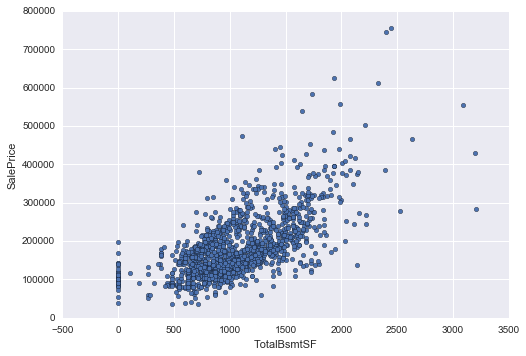

In [18]:
# Bivariate analysis SalePrice/TotalBsmtSF
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 8e5))

We can feel tempted to eliminate some observations(e.g. TotalBsmtSF > 3000) but it's not worth it. We can live with that, so we'll not do anything.

## In the search for normality
The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:
* Histogram - Kurtosis and skewness.
* Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

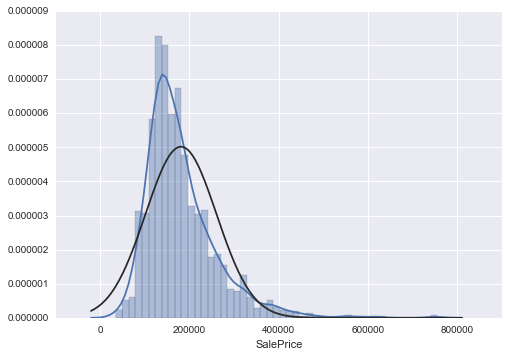

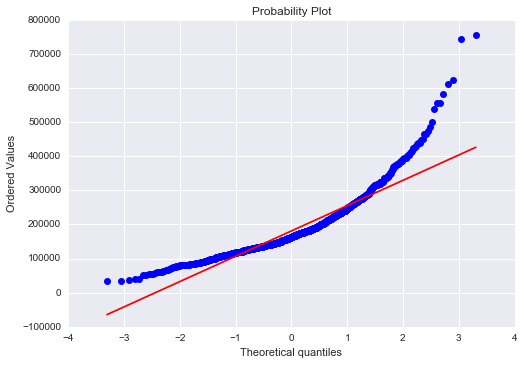

In [19]:
# histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books:
> In case of positive skewness, log transformations usually works well

In [20]:
# applying log transformation
train['SalePrice'] = np.log1p(train.SalePrice)

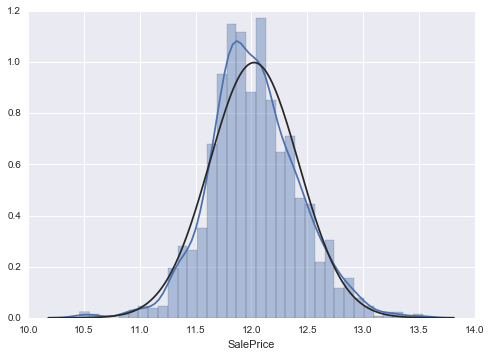

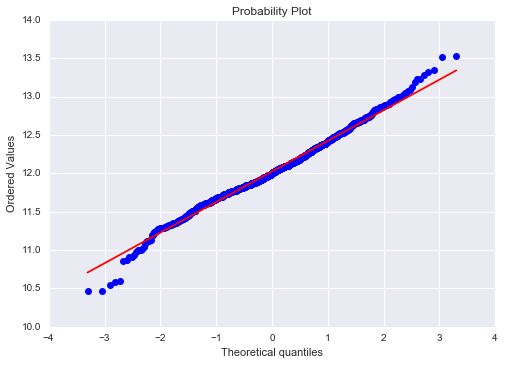

In [21]:
# transformed histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Done! Let's check what's going on with 'GrLivArea'

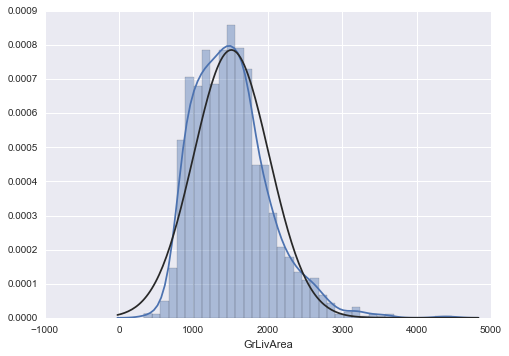

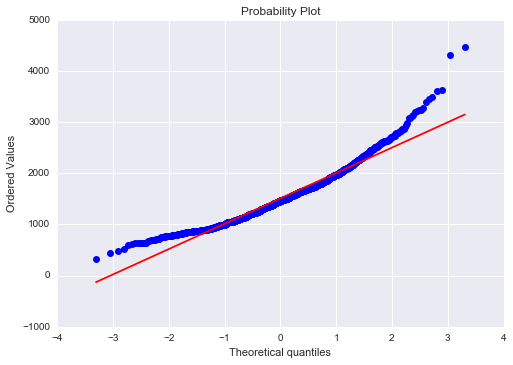

In [22]:
# histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

In [23]:
# applying log transformation
train['GrLivArea'] = train.GrLivArea.map(np.log)

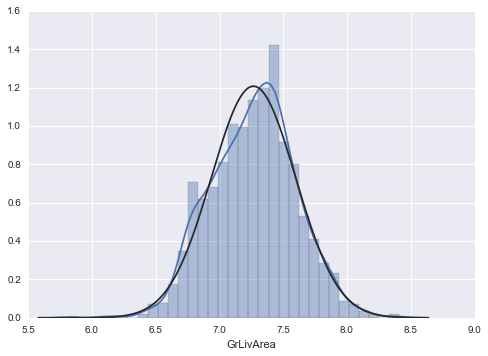

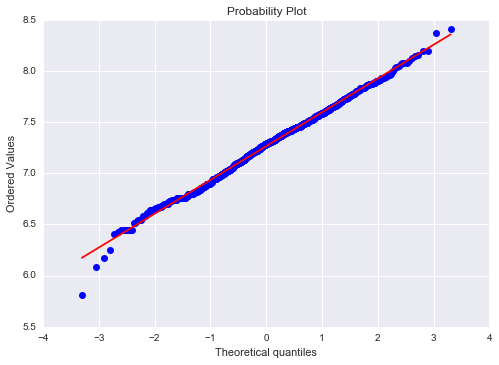

In [24]:
# transformed histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

Next is TotalBsmtSF...

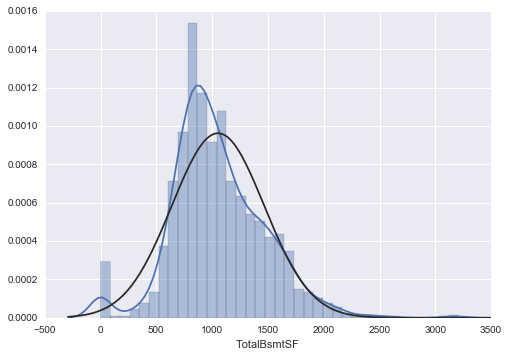

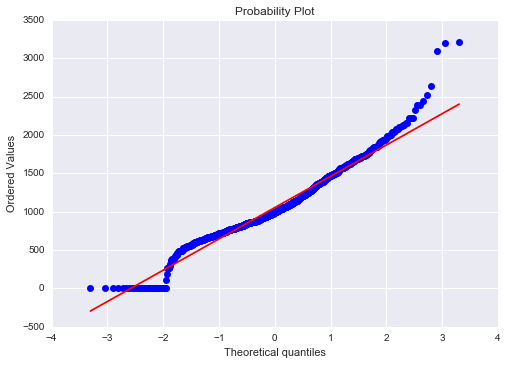

In [25]:
sns.distplot(train['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

What do we have here?
* Something that, in general, presents skewness.
* A significant number of observations with value zero(houses without basement)
* A big problem because the value zero doesn't allow us to do log tranform

To apply a log tranformation here, we'll create a variable that can get the effect of having or not having basement(binary). Then, we'll do a log transformation to all non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

In [26]:
train['TotalBsmtSF'] = np.log1p(train.TotalBsmtSF)

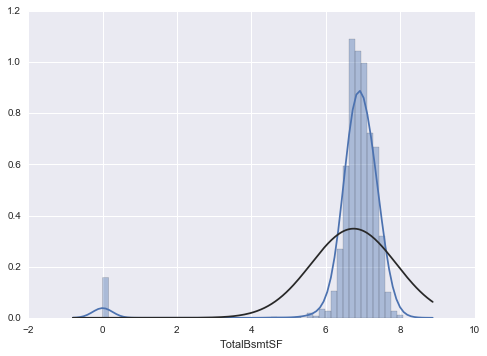

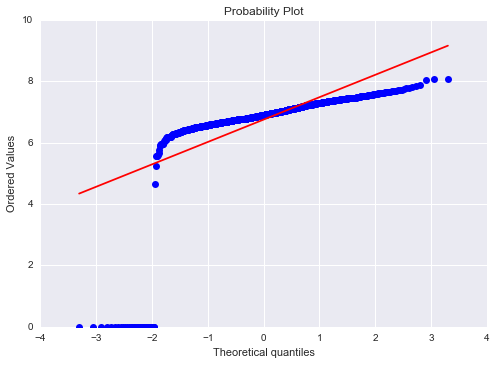

In [27]:
sns.distplot(train['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

In [28]:
train = pd.get_dummies(train)
train.head(5)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,0,1,0


In [29]:
y = train.SalePrice
drop_cols = ['Id', 'SalePrice', '1stFlrSF', 'GarageArea']
X = train.drop(drop_cols, axis=1)

In [78]:
class Regressor:
    def __init__(self):
        self.regs = []
        reg = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3,
                                        max_features='sqrt',min_samples_leaf=15,
                                        min_samples_split=10, loss='huber')
        self.regs.append(reg)
        reg = ElasticNetCV()
        self.regs.append(reg)
        
    def fit(self, X, y):
        for reg in self.regs:
            reg.fit(X, y)
    
    def predict(self, X):
        h = []
        for reg in self.regs:
            h.append(reg.predict(X))
        df = pd.DataFrame({'SalePrice_{}'.format(idx): pre for idx, pre in enumerate(h)})
        return df

In [79]:
regressor = Regressor()
regressor.fit(X, y)

# Prepare test data

In [32]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [33]:
test['TotalBsmtSF'] = np.log1p(test.TotalBsmtSF)
test = pd.get_dummies(test)

In [34]:
ids = test.Id.astype(str)
test = test.loc[:, X.columns.values]
test.head(5)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,11622,5,6,1961,1961,468.0,144.0,270.0,6.783325,...,0,0,0,1,0,0,0,0,1,0
1,20,14267,6,6,1958,1958,923.0,0.0,406.0,7.192934,...,0,0,0,1,0,0,0,0,1,0
2,60,13830,5,5,1997,1998,791.0,0.0,137.0,6.834109,...,0,0,0,1,0,0,0,0,1,0
3,60,9978,6,6,1998,1998,602.0,0.0,324.0,6.831954,...,0,0,0,1,0,0,0,0,1,0
4,120,5005,8,5,1992,1992,263.0,0.0,1017.0,7.155396,...,0,0,0,1,0,0,0,0,1,0


In [35]:
test = test.fillna(0)

In [80]:
h = np.expm1(regressor.predict(test)).mean(axis=1)
h

0       148827.062895
1       194422.718703
2       227156.253679
3       230110.628728
4       231486.336212
5       203608.165172
6       227729.547263
7       199296.697189
8       227225.054591
9       158475.770693
10      251654.609515
11      126897.332904
12      124374.855142
13      175516.819460
14      142110.621098
15      376294.990365
16      294567.158517
17      323934.446799
18      320879.087199
19      537695.017796
20      341360.128971
21      252251.893536
22      224915.931565
23      206044.248998
24      221730.153241
25      224835.872469
26      342156.196525
27      267000.083021
28      255280.667862
29      292258.635551
            ...      
1429    113647.816480
1430    155089.613580
1431     76223.850276
1432    106215.983697
1433     90550.907000
1434    354139.363883
1435    317455.547846
1436    228145.179306
1437    178191.177655
1438    251322.229155
1439    191795.468199
1440    244278.682802
1441    240386.044794
1442    366760.810971
1443    41

In [81]:
answer = pd.DataFrame({'Id': ids, 'SalePrice': h})

answer.to_csv('data/submit.csv', index=False, float_format='%.3f')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115b5ba90>]], dtype=object)

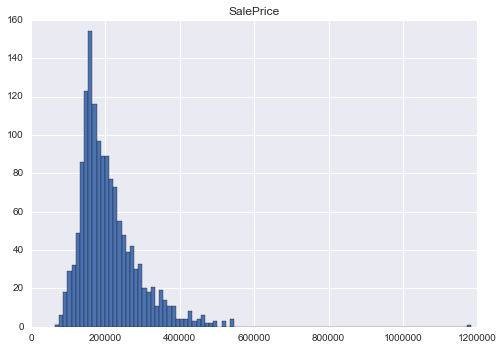

In [82]:
df = pd.DataFrame(h, columns=['SalePrice'])
df.hist(bins=100)

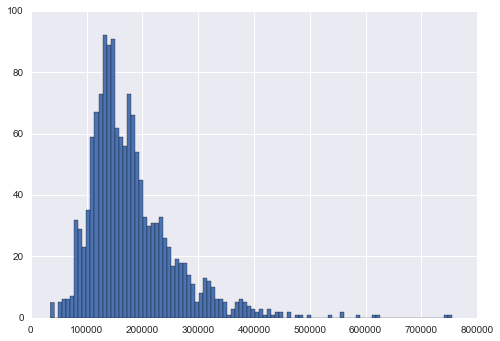

In [76]:
y.map(np.expm1).hist(bins=100)